# 01 — Data Quality Profile (Gold Extracts)

This notebook performs lightweight data quality checks on the sample Gold-layer extracts. The goal is to demonstrate practical checks used in commercial environments: nulls, duplicates, referential integrity, and basic anomaly flags.

**Why this matters:** In commercial analytics, poor data quality (null keys, duplicates, broken joins) can invalidate KPI reporting and decision-making. This notebook demonstrates practical checks to build trust before analysis.

In [1]:
"""Repository bootstrap for notebooks and ad-hoc execution.

This module ensures the repository root (the directory containing 'src/') is added
to sys.path so that imports like `from src...` work reliably when running
notebooks from the /notebooks folder (or any subfolder inside the repo).
"""
import bootstrap


In [2]:
import sys
from pathlib import Path


In [3]:
import pandas as pd
import numpy as np

from src.io import load_sample, project_root
from src import quality
#from src import metrics
from src.viz import line_chart, barh_top

dfs = load_sample()
fact = dfs["fact_sales"]
dim_customers = dfs["dim_customers"]
dim_products = dfs["dim_products"]
report_customers = dfs["report_customers"]
report_products = dfs["report_products"]

fact.head()


,order_number,product_key,customer_key,order_date,shipping_date,due_date,sales_amount,quantity,price
0,SO54496,282,5400,2013-03-16,2013-03-23,2013-03-28,25,1,25
1,SO54496,289,5400,2013-03-16,2013-03-23,2013-03-28,5,1,5
2,SO54496,259,5400,2013-03-16,2013-03-23,2013-03-28,2,1,2
3,SO54497,174,9281,2013-03-16,2013-03-23,2013-03-28,22,1,22
4,SO54497,280,9281,2013-03-16,2013-03-23,2013-03-28,9,1,9


In [4]:
# Schema validation (fail fast if inputs change)
from src.core.schema_checks import assert_required_columns, REQUIRED

assert_required_columns(fact, REQUIRED["fact_sales"], "fact_sales")
assert_required_columns(dim_customers, REQUIRED["dim_customers"], "dim_customers")
assert_required_columns(dim_products, REQUIRED["dim_products"], "dim_products")

In [7]:
# Null rates (top 15)
nulls = quality.null_rate(fact).head(15)
nulls


order_number     0.0
product_key      0.0
customer_key     0.0
order_date       0.0
shipping_date    0.0
due_date         0.0
sales_amount     0.0
quantity         0.0
price            0.0
dtype: float64

In [8]:
# Duplicate checks
dup_orders = quality.duplicate_key_count(fact, ["order_number", "product_key"])
dup_customers = quality.duplicate_key_count(dim_customers, ["customer_key"])
dup_products = quality.duplicate_key_count(dim_products, ["product_key"])

pd.DataFrame({
    "table": ["fact_sales", "dim_customers", "dim_products"],
    "key_cols": ["order_number+product_key", "customer_key", "product_key"],
    "duplicate_rows": [dup_orders, dup_customers, dup_products],
})


,table,key_cols,duplicate_rows
0,fact_sales,order_number+product_key,0
1,dim_customers,customer_key,0
2,dim_products,product_key,0


In [9]:
# Referential integrity (fact -> dims)
cust_viol = quality.referential_integrity_violations(fact, dim_customers, "customer_key", "customer_key")
prod_viol = quality.referential_integrity_violations(fact, dim_products, "product_key", "product_key")

pd.DataFrame({
    "relationship": ["fact_sales.customer_key -> dim_customers.customer_key", "fact_sales.product_key -> dim_products.product_key"],
    "missing_dim_keys": [cust_viol, prod_viol],
})


,relationship,missing_dim_keys
0,fact_sales.customer_key -> dim_customers.custo...,0
1,fact_sales.product_key -> dim_products.product...,0


In [10]:
# Basic anomaly flags
anomalies = fact.copy()
anomalies["is_negative_qty"] = anomalies["quantity"] < 0
anomalies["is_negative_sales"] = anomalies["sales_amount"] < 0
anomalies["is_zero_price"] = anomalies["price"] <= 0

summary = pd.DataFrame({
    "flag": ["negative_qty", "negative_sales", "zero_or_negative_price"],
    "rows": [anomalies["is_negative_qty"].sum(), anomalies["is_negative_sales"].sum(), anomalies["is_zero_price"].sum()]
})
summary


,flag,rows
0,negative_qty,0
1,negative_sales,0
2,zero_or_negative_price,0


In [11]:
# Export a DQ summary table
out = pd.concat([
    summary,
    pd.DataFrame({"flag":["missing_customer_keys_in_dim","missing_product_keys_in_dim"],"rows":[cust_viol, prod_viol]})
], ignore_index=True)


out_path = project_root() / "outputs/tables/dq_summary.csv"
from pathlib import Path
Path(out_path).parent.mkdir(parents=True, exist_ok=True)
out.to_csv(out_path, index=False)
out_path


WindowsPath('C:/Users/uvcha/Python_Data_Analysis_Project_Fortis_Aligned_bootstrap/Python_Data_Analysis_Project_Fortis_Aligned/outputs/tables/dq_summary.csv')

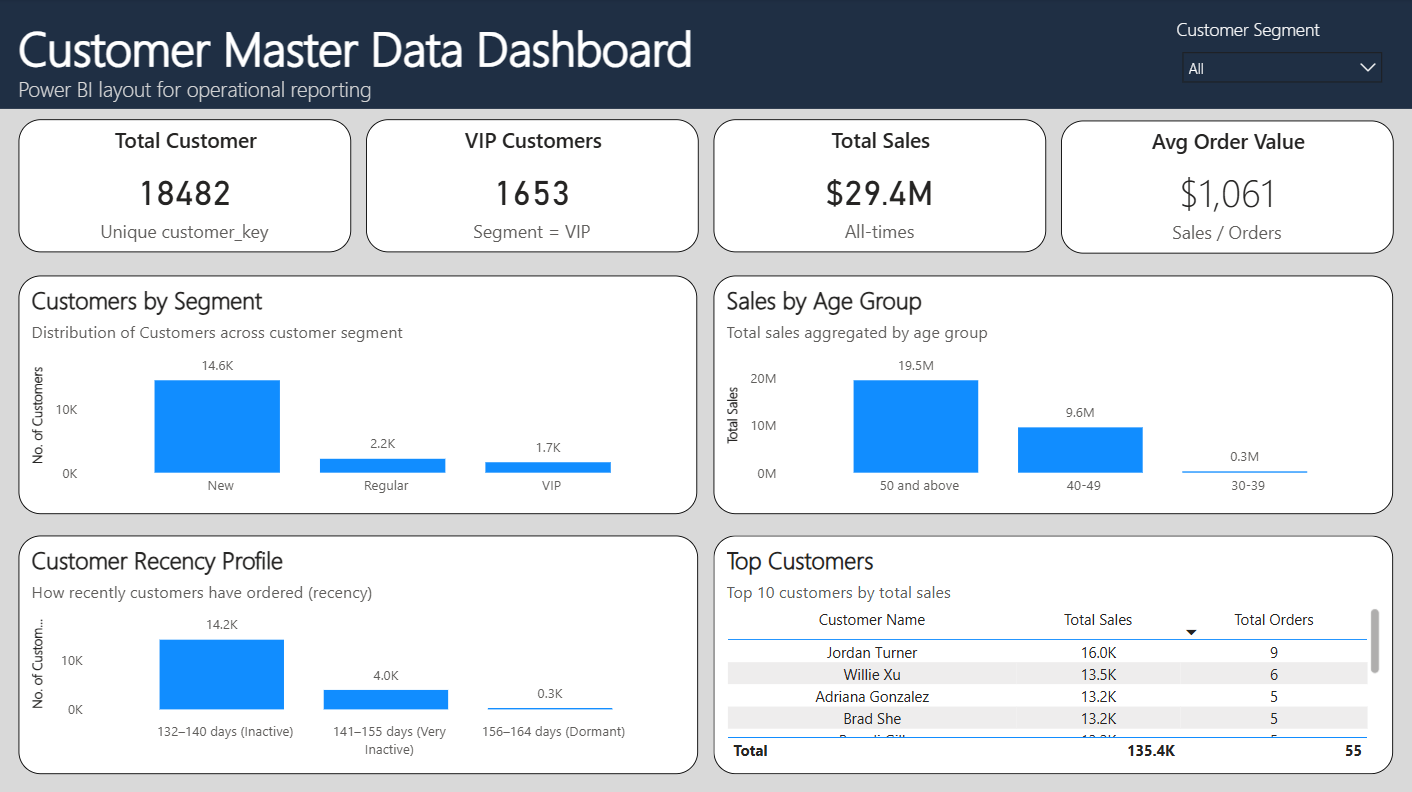

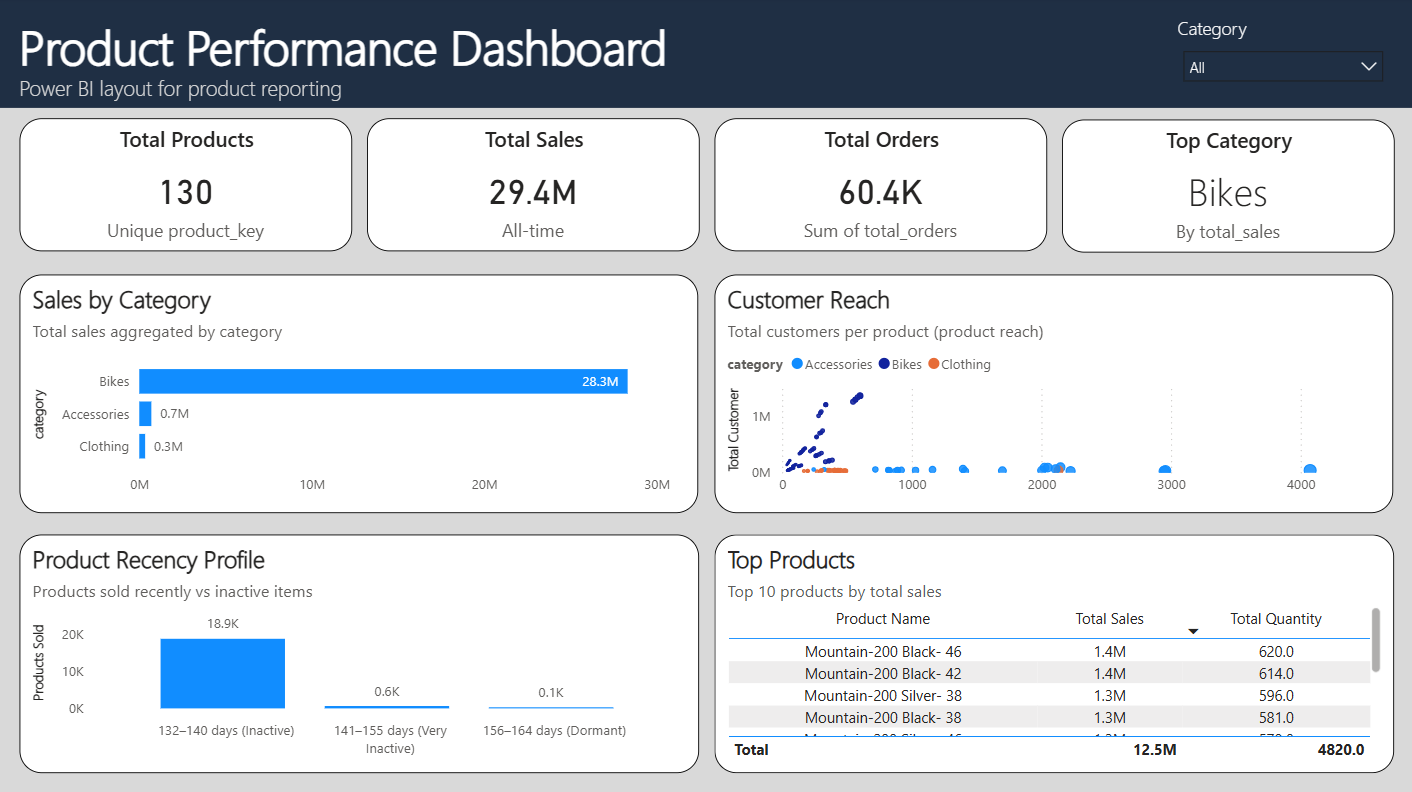

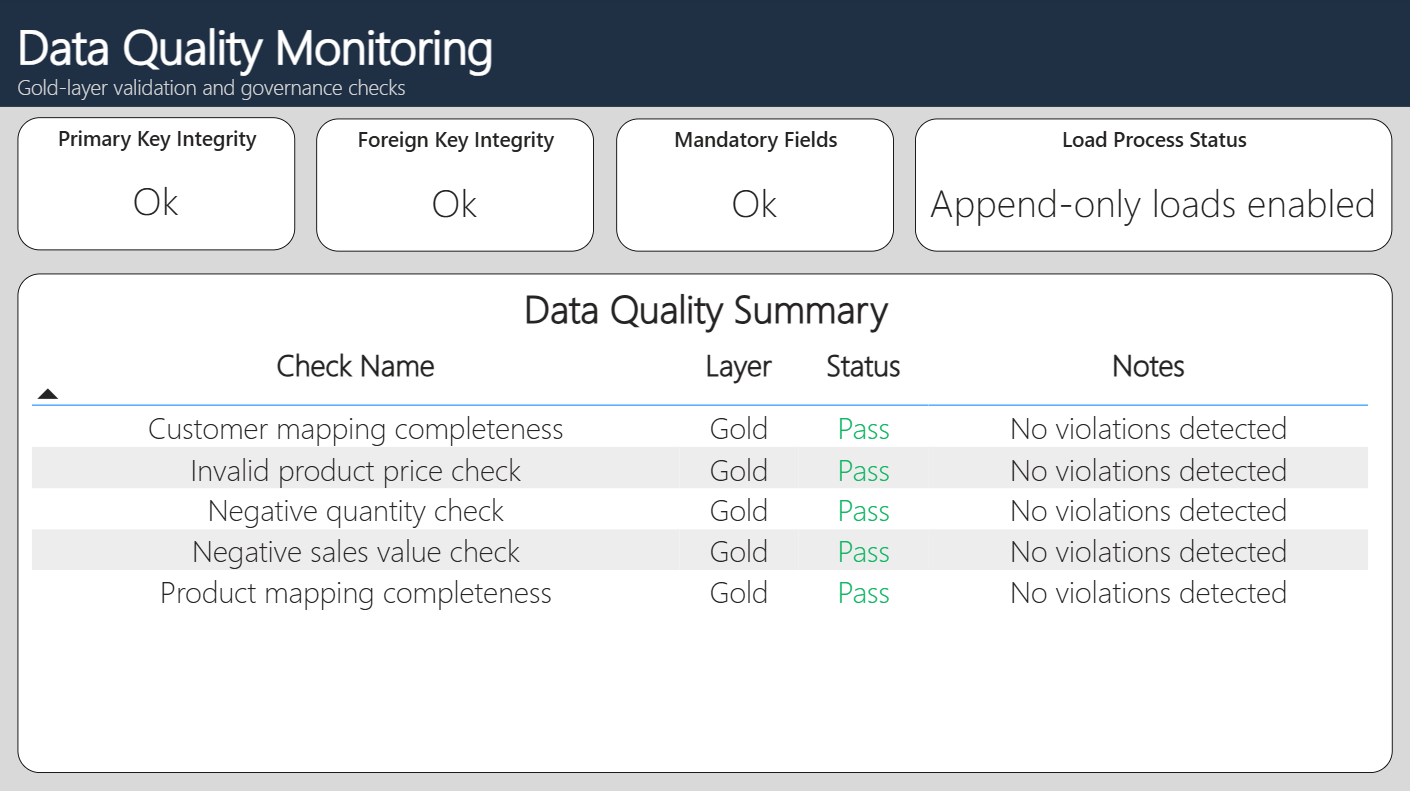

In [12]:
# Recruiter-friendly: dashboard preview at the end (no scrolling)
from IPython.display import Image, display

for fp in [
    "../powerbi/screenshots/dashboard_customer_360.png",
    "../powerbi/screenshots/dashboard_product_performance.png",
    "../powerbi/screenshots/dashboard_data_quality.png",
]:
    display(Image(filename=fp, width=1200))